## Context Based Pedestrian Path Prediction
    This is my implementation of this paper[1].
    Written by yashengsun. 
    Email: sunyasheng123@gmail.com

### Reference
    [1]"Context-Based Pedestrian Path Prediction",
    Julian F. P. Kooij, Nicolas Schneider, Fabian Flohr, and Dariu M. Gavrila,
    ECCV 2014

## Dataset Preprocessing
Read data and split it into training set and testing set.

In [592]:
import numpy as np
import pandas as pd
import os
import json
import numpy as np
from numpy.linalg import inv
from pprint import pprint
import random
from scipy.special import gamma
import math
from scipy import stats
import scipy
from sklearn.naive_bayes import MultinomialNB

data_filename = '../data/contextpathpred_daimler_dataset_eccv14.json'

assert os.path.exists(data_filename), 'path does not exists:{}'.format(data_filename)

with open(data_filename, 'r') as f:
    sequences = json.load(f)

## split the sequences into the training and testing dataset
ratio_train = 1.0
num_sequences = 0
train_list = []
test_list = []

for _,value in sequences.items():
    num_sequences = len(value)
    num_train = int(ratio_train*num_sequences)
    id_in_train = random.sample(range(num_sequences), num_train)
    for i in range(len(value)):
        if i in id_in_train:
            train_list.append(value[i])
        else:
            test_list.append(value[i])


# Learning
### 1. Transition Probability Estimation
    In this section, the conditional probability distribution of the context transformation between adjacent time slices will be approximated through the maximum likelihood estimation(MLE) with the Laplacian smoothing technique.

In [593]:
Prob = {}
Prob['HSV'] = np.zeros(shape=(2,2,2))
Prob['SV'] = np.zeros(shape=(2,2))
Prob['SC'] = np.zeros(shape=(2,2))
Prob['AC'] = np.zeros(shape=(2,2))

###################### HSV #################################
for i in (0,1):
    for j in (0,1):
        for k in (0,1):
            Prob['HSV'][k][j][i] = 1 if k==(j or i) else 0
#             print('({},{},{},{})'.format(i,j,k, Prob['HSV'][k][j][i]))

####################### SV #################################
for i in range(len(train_list)):
    for j in range(len(train_list[i]['sv'])):
        if j:
            Prob['SV'][train_list[i]['sv'][j]][train_list[i]['sv'][j-1]] += 1
            
Prob['SV'] += 1
Prob['SV'] /= np.sum(Prob['SV'], axis = 0, keepdims = 1)

###################### SC ##################################
for i in (0,1):
    for j in (0,1):
        Prob['SC'][i][j] = 0.01 if i!=j else 0.99

###################### AC #################################
for i in range(len(train_list)):
    for j in range(len(train_list[i]['ac'])):
        if j:
            Prob['AC'][train_list[i]['ac'][j]][train_list[i]['ac'][j-1]] += 1
Prob['AC'] += 1
Prob['AC'] /= np.sum(Prob['AC'], axis = 0, keepdims = 1)

###################### M ###################################
Prob['M'] = np.zeros(shape = (2,2,2,2,2))
temp = np.zeros(shape = (2,2,2,2))
for i in range(len(train_list)):
    for j in range(len(train_list[i]['M'])):
        if j:
            Prob['M'][train_list[i]['M'][j]-1][train_list[i]['M'][j-1]-1][train_list[i]['hsv'][j]][train_list[i]['sd'][j]][train_list[i]['ac'][j]] += 1
            temp[train_list[i]['M'][j-1]-1][train_list[i]['hsv'][j]][train_list[i]['sd'][j]][train_list[i]['ac'][j]] += 1
Prob['M'] += 1
temp += 2

for m_cur in (0,1):
    for m_prev in (0,1):
        for hsv in (0,1):
            for sc in (0,1):
                for ac in (0,1):
                    Prob['M'][m_cur][m_prev][hsv][sc][ac]/=temp[m_prev][hsv][sc][ac]
#                     if m_prev==0 and m_cur==1:
#                         print('m_cur: ', m_cur, ' m_prev: ', m_prev, ' hsv: ', hsv, ' sv: ', sv, ' ac: ', ac)
#                         print(Prob['M'][m_cur][m_prev][hsv][sc][ac])

#################### MZ init ##############################
P_mz_init = np.zeros(shape = (2,2,2,2,2))
for i in range(len(train_list)):
    for j in range(len(train_list[i]['M'])):
        P_mz_init[train_list[i]['M'][j]-1][train_list[i]['hsv'][j]][train_list[i]['sv'][j]][train_list[i]['sd'][j]][train_list[i]['ac'][j]] += 1
        
P_mz_init /= np.sum(P_mz_init)
# Prob['AC'][0][0] = 0.4
# Prob['AC'][1][0] = 0.6
# Prob['AC'][0][1] = 0.05
# Prob['AC'][1][1] = 0.95
# print(P_mz_init)
# print(Prob['SV'])
# print(Prob['SC'])
# print(Prob['AC'])




## 2. Emission Probability Estimation
    Here we estimate the emission probability $P(HO_t|SV_t)$ $P(D_t^{min}|SC_t)$ and
$P(DTC|AC_t)$ in the same time steps. $P(D_t^{min}|SC_t)$ is estimated by maximum likelihood estimation following [1].
    


### Reference:
[1]https://web.kamihq.com/web/viewer.html?source=extension_pdfhandler&file=https%3A%2F%2Ftminka.github.io%2Fpapers%2Fminka-gamma.pdf

In [594]:
##################### P(D_t^{min}|SC_t) ########################
def gamma_mle(epsilon, a, mean_logx, log_meanx):
    new_a = 1/(1/a + (mean_logx - log_meanx + math.log(a) - scipy.special.digamma(a) )/(a*a*(1/a - scipy.special.polygamma(1,a))))
    if abs(new_a-a) < epsilon:
        return new_a
    else:
        return gamma_mle(epsilon, new_a, mean_logx, log_meanx)

sc = [[],[]]
for i in range(len(train_list)):
    for j in range(len(train_list[i]['dmin'])):
        if isinstance(train_list[i]['dmin'][j], str):
            continue
        sc[train_list[i]['tags']['sitdang']=='true'].append(train_list[i]['dmin'][j])


log_sc = [[],[]]
log_sc[0] = [math.log(x) for x in sc[0]]
log_sc[1] = [math.log(x) for x in sc[1]]
Prob['Dmin'] = {}
Prob['Dmin']['a'] = [[],[]]
Prob['Dmin']['b'] = [[],[]]
mean_logx = [[],[]]
log_meanx = [[],[]]
a_init = [[],[]]
epsilon = 1e-5
for i in (0,1):
    mean_logx[i] = np.mean(log_sc[i])
    log_meanx[i] = math.log(np.mean(sc[i]))
    a_init[i] = 0.5/(log_meanx[i] - mean_logx[i])
    Prob['Dmin']['a'][i] = gamma_mle(epsilon, a_init[i], mean_logx[i], log_meanx[i])
    Prob['Dmin']['b'][i] = np.mean(sc[i])/Prob['Dmin']['a'][i]

##################### P(DTC|AC_t) ##############################
ac = [[],[]]
for i in range(len(train_list)):
    for j in range(len(train_list[i]['curb_dist'])):
        if isinstance(train_list[i]['curb_dist'][j], str) or isinstance(train_list[i]['ac'][j], str):
            continue
        ac[train_list[i]['ac'][j]].append(train_list[i]['curb_dist'][j])

ac[0] = np.array(ac[0])
ac[1] = np.array(ac[1])

Prob['DTC'] = {}
Prob['DTC']['mean'] = [[],[]]
Prob['DTC']['std'] = [[],[]]
for i in (0,1):
    Prob['DTC']['mean'][i] = np.mean(ac[i])
    Prob['DTC']['std'][i] = np.std(ac[i])


####################### Observation Noise #########################
count, var = 0., 0.
for i in range(len(train_list)):
    for j in range(len(train_list[i]['gt_pos_e'][0])):
        if isinstance(train_list[i]['gt_pos_e'][0][j], str) or isinstance(train_list[i]['meas_pos_e'][0][j], str):
            continue 
        count += 1
        var += (train_list[i]['gt_pos_e'][0][j] - train_list[i]['meas_pos_e'][0][j])*\
        (train_list[i]['gt_pos_e'][0][j] - train_list[i]['meas_pos_e'][0][j])
R = var/count

####################### Process Noise #########################
count, var, m_count, velocity = 0., 0., 0., 0.
for i in range(len(train_list)):
    for j in range(len(train_list[i]['gt_pos_e'][0])):
        if j<=1 or isinstance(train_list[i]['gt_pos_e'][0][j], str) or isinstance(train_list[i]['M'][j],str):
            continue
        if train_list[i]['M'][j] == 2 and isinstance(train_list[i]['gt_pos_e'][0][j-1], str):
            continue
        count += 1
        if train_list[i]['M'][j] == 2:
            m_count += 1
            velocity *= ((m_count-1.)/m_count)
            velocity += (train_list[i]['gt_pos_e'][0][j] - train_list[i]['gt_pos_e'][0][j-1])/m_count
            var += (train_list[i]['gt_pos_e'][0][j] - (train_list[i]['gt_pos_e'][0][j-1] + velocity))*\
                (train_list[i]['gt_pos_e'][0][j] - (train_list[i]['gt_pos_e'][0][j-1] + velocity))
        else:
            var += (train_list[i]['gt_pos_e'][0][j] - (train_list[i]['gt_pos_e'][0][j-1] ))*\
                (train_list[i]['gt_pos_e'][0][j] - (train_list[i]['gt_pos_e'][0][j-1] ))
QQ = var/count
# print('R:', R)
# print('Q:', QQ)
# print(Prob['DTC']['mean'])
# print(Prob['DTC']['std'])

## Infer under the DBN Framework

In [595]:
state_num = 2
A = [np.matrix([[1,0],[0,1]]), np.matrix([[1,1],[0,1]])]
H = np.matrix([1,0])
Q = np.matrix([[QQ,0],[0,QQ]])

INF = 1e9
MIN_POS = 1e-20


In [596]:
def predict(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post):
    P_mmzz_prior = np.zeros(shape=(2,2,2,2,2,2,2,2,2,2))#M_t, M_t-1, HSV_t, SC_t, AC_t, HSV_t-1, SC_t-1, AC_t-1
    temp = 0.
    for m_cur in (0,1):
        for m_prev in (0,1):
            for hsv_cur in (0,1):
                for sv_cur in (0,1):
                    for sc_cur in (0,1):
                        for ac_cur in (0,1):
                            for hsv_prev in (0,1):
                                for sv_prev in (0,1):
                                    for sc_prev in (0,1):
                                        for ac_prev in (0,1):
                                            P_mmzz_prior[m_cur][m_prev][hsv_cur][sv_cur][sc_cur][ac_cur][hsv_prev][sv_prev][sc_prev][ac_prev]=\
                                                Prob['M'][m_cur][m_prev][hsv_cur][sc_cur][ac_cur] *\
                                                Prob['HSV'][hsv_cur][hsv_prev][sv_cur] *\
                                                Prob['SV'][sv_cur][sv_prev] *\
                                                Prob['SC'][sc_cur][sc_prev] *\
                                                Prob['AC'][ac_cur][ac_prev] *\
                                                P_mz_post[m_prev][hsv_prev][sv_prev][sc_prev][ac_prev]

    assert abs(np.sum(P_mz_post)-1)<1e-7, 'P_mz_post{} does not sum to 1'.format(np.sum(P_mz_post))
    assert abs(np.sum(P_mmzz_prior)-1)<1e-6, 'P_mmzz_prior({}) does not sum to 1'.format(np.sum(P_mmzz_prior))
    P_mmzz_prior /= np.sum(P_mmzz_prior) # renormalization since calculation is unstable here
    P_mean_xmm_prior = {0:{},1:{}}
    P_covariance_xmm_prior = {0:{},1:{}}

    for m_pre in (0,1):
        for m_cur in (0,1):
            P_mean_xmm_prior[m_cur][m_pre], P_covariance_xmm_prior[m_cur][m_pre] = \
            kf_predict(P_mean_xGm_post[m_pre], P_covariance_xGm_post[m_pre], A[m_cur], Q)
        
    return P_mmzz_prior, P_mean_xmm_prior, P_covariance_xmm_prior


In [597]:
def update(P_mmzz_prior, P_mean_xmm_prior, P_covariance_xmm_prior, meas_y, d_min, meas_pos_e, meas_curb_pos_e, meas_ho):
    P_mmzz_post = np.zeros(shape=(2,2,2,2,2,2,2,2,2,2))#M_t, M_t-1, HSV_t, SC_t, AC_t, HSV_t-1, SC_t-1, AC_t-1
    S = np.zeros(shape=(2,2))
    P_mean_xmm_post = {0:{},1:{}}
    P_covariance_xmm_post = {0:{},1:{}}
    
    for m_cur in (0,1):
        for m_pre in (0,1):
            if meas_y != 'None':
                P_mean_xmm_post[m_cur][m_pre], P_covariance_xmm_post[m_cur][m_pre], S[m_cur][m_pre] =\
                kf_update(P_mean_xmm_prior[m_cur][m_pre], P_covariance_xmm_prior[m_cur][m_pre], R, H, meas_y)
            else:
                P_mean_xmm_post[m_cur][m_pre], P_covariance_xmm_post[m_cur][m_pre] =\
                P_mean_xmm_prior[m_cur][m_pre], P_covariance_xmm_prior[m_cur][m_pre]

########################################### Observation  ########################################   
    
    Obs = {}
    Obs['meas_ho'] = np.zeros(shape=(2))
    Obs['meas_ho'].fill(0.5)
    if meas_ho != 'None':
        Obs['meas_ho']  = meas_ho
        Obs['meas_ho']/=np.sum(Obs['meas_ho'])
#         temp_sum = 0
#         for k in range(8):
#             temp_sum += meas_ho[k]
#         for sv in (0,1):
#             for k in range(8):
#                 Obs['meas_ho'][sv] *= Prob['HO'][sv][k]**(meas_ho[k])        

    
    Obs['meas_y'] = np.zeros(shape =(2,2))
    Obs['meas_y'].fill(1./4)
    if meas_y != 'None':
        for m_cur in (0,1):
            for m_prev in (0,1):
                Obs['meas_y'][m_cur][m_prev] = 1.0/S[m_cur][m_prev]*np.exp(-0.5*((meas_y - H*P_mean_xmm_prior[m_cur][m_prev])/S[m_cur][m_prev])**2)
                #scipy.stats.norm.pdf((meas_y - H*P_mean_xmm_prior[m_cur][m_prev])/S[m_cur][m_prev])
    
    Obs['meas_y']/= np.sum(Obs['meas_y'])
    
    
    Obs['sc'] = np.zeros(shape = (2))
    Obs['sc'].fill(0.5)
    if d_min != 'None':
        for sc in (0,1):
            a, b = Prob['Dmin']['a'][sc], Prob['Dmin']['b'][sc]
            Obs['sc'][sc] = d_min**(a-1)*np.exp(-d_min/b)/(gamma(a)*b**a)
            #scipy.stats.gamma.pdf(d_min, a = Prob['Dmin']['a'][sc], scale = Prob['Dmin']['b'][sc])
        Obs['sc'] /= np.sum(Obs['sc'])    
        Obs['sc'][0] = 0.05
        Obs['sc'][1] = 0.95
    
    Obs['ac'] = np.zeros(shape = (2))
    Obs['ac'].fill(0.5)
    if meas_pos_e != 'None' and meas_curb_pos_e != 'None':
        for ac in (0,1):
            Obs['ac'][ac] = 1.0/Prob['DTC']['std'][ac]*np.exp(-0.5*((meas_pos_e - meas_curb_pos_e - Prob['DTC']['mean'][ac])/Prob['DTC']['std'][ac])**2)
            #scipy.stats.norm.pdf((meas_pos_e - meas_curb_pos_e - Prob['DTC']['mean'][ac])/Prob['DTC']['std'][ac])
        Obs['ac'][0] = 0.1
        Obs['ac'][1] = 0.9
    Obs['ac'] /= np.sum(Obs['ac'])
    
    
    for m_cur in (0,1):
        for m_prev in (0,1):
            for hsv_cur in (0,1):
                for sv_cur in (0,1):
                    for sc_cur in (0,1):
                        for ac_cur in (0,1):
                            for hsv_prev in (0,1):
                                for sv_prev in (0,1):
                                    for sc_prev in (0,1):
                                        for ac_prev in (0,1):
                                            P_mmzz_post[m_cur][m_prev][hsv_cur][sv_cur][sc_cur][ac_cur][hsv_prev][sv_prev][sc_prev][ac_prev]=\
                                            math.exp(math.log(Obs['ac'][ac_cur] + MIN_POS)+\
                                                     math.log(Obs['sc'][sc_cur] + MIN_POS)+\
                                                     math.log(Obs['meas_ho'][sv_cur] + MIN_POS)+\
                                                     math.log(Obs['meas_y'][m_cur][m_prev] + MIN_POS)+\
                                                     math.log(P_mmzz_prior[m_cur][m_prev][hsv_cur][sv_cur][sc_cur][ac_cur][hsv_prev][sv_prev][sc_prev][ac_prev] + MIN_POS))
    P_mmzz_post /= np.sum(P_mmzz_post)
#     print("meas_ho:",Obs['meas_ho'])
#     print("sc:",Obs['sc'])
#     print("meas_y:",Obs['meas_y'])
#     print("ac:",Obs['ac'])
    return P_mmzz_post, P_mean_xmm_post, P_covariance_xmm_post

In [598]:
def collapse(P_mmzz_post, P_mean_xmm_post, P_covariance_xmm_post):
    P_mz_post = np.zeros(shape=(2,2,2,2,2))
    P_mean_xGm_post = [np.matrix([[0],[0]]), np.matrix([[0],[0]])]
    P_covariance_xGm_post = [np.matrix([[INF,0],[0,INF]]), np.matrix([[INF,0],[0,INF]])]

######################### calculate the P(M_t|M_t-1) the weight in Gaussian Mixture ############################## 

    Prob_Motion = {'joint':np.zeros(shape=(2,2)),'condition':np.zeros(shape=(2,2))}
    for m_cur in (0,1):
        for m_prev in (0,1):
            Prob_Motion['joint'][m_cur][m_prev] = 0
    
    for m_cur in (0,1):
        for m_prev in (0,1):
            for hsv_cur in (0,1):
                for sv_cur in (0,1):
                    for sc_cur in (0,1):
                        for ac_cur in (0,1):
                            for hsv_prev in (0,1):
                                for sv_prev in (0,1):
                                    for sc_prev in (0,1):
                                        for ac_prev in (0,1):
                                            P_mz_post[m_cur][hsv_cur][sv_cur][sc_cur][ac_cur] +=\
                                            P_mmzz_post[m_cur][m_prev][hsv_cur][sv_cur][sc_cur][ac_cur][hsv_prev][sv_prev][sc_prev][ac_prev]
                                            Prob_Motion['joint'][m_cur][m_prev] +=\
                                            P_mmzz_post[m_cur][m_prev][hsv_cur][sv_cur][sc_cur][ac_cur][hsv_prev][sv_prev][sc_prev][ac_prev]

    assert abs(np.sum(Prob_Motion['joint']) - 1)<1e-6, 'Prob_Motion {} does not sum to 1'.format(np.sum(Prob_Motion['joint']))
    for m_prev in (0,1):
        for m_cur in (0,1):
            Prob_Motion['condition'][m_cur][m_prev] = \
            Prob_Motion['joint'][m_cur][m_prev]/(Prob_Motion['joint'][m_cur][0] + Prob_Motion['joint'][m_cur][1])

########################### Expectation Propogation ##############################################################
# use the approximate gaussian distribution posterio to describe exact posterio through KL divergence minimization
    for m_cur in (0,1):
        P_mean_xGm_post[m_cur] = Prob_Motion['condition'][m_cur][0]*P_mean_xmm_post[m_cur][0] +\
                        Prob_Motion['condition'][m_cur][1]*P_mean_xmm_post[m_cur][1]
        P_covariance_xGm_post[m_cur] = Prob_Motion['condition'][m_cur][0]*(P_covariance_xmm_post[m_cur][0] +\
                        (P_mean_xmm_post[m_cur][0]-P_mean_xGm_post[m_cur])*(P_mean_xmm_post[m_cur][0]-P_mean_xGm_post[m_cur]).T) +\
                                Prob_Motion['condition'][m_cur][1]*(P_covariance_xmm_post[m_cur][1] +\
                        (P_mean_xmm_post[m_cur][1]-P_mean_xGm_post[m_cur])*(P_mean_xmm_post[m_cur][1]-P_mean_xGm_post[m_cur]).T)
                        
        
    return P_mz_post, P_mean_xGm_post, P_covariance_xGm_post

In [599]:
def kf_predict(x_t_minus, P_t_minus, A, Q):
    x_prior = A*x_t_minus
    P_prior = A*P_t_minus*A.T + Q

    return x_prior, P_prior

def kf_update(x_prior, P_prior, R, H, z):
    I = np.matrix(np.identity(x_prior.shape[0]))
    y = z - H*x_prior
    S = R + H*P_prior*H.T
    K = P_prior*H.T*inv(S)
    x_post = x_prior + K*y
    P_post = (I - K*H)*P_prior*(I-K*H).T + K*R*K.T

    return x_post, P_post, S

In [600]:
def dbn(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post, meas_y, d_min, meas_pos_e, meas_curb_pos_e, meas_ho):
    P_mmzz_prior, P_mean_xmm_prior, P_covariance_xmm_prior = predict(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post)
    P_mmzz_post, P_mean_xmm_post, P_covariance_xmm_post = update(P_mmzz_prior, P_mean_xmm_prior, P_covariance_xmm_prior, meas_y, d_min, meas_pos_e, meas_curb_pos_e, meas_ho)
    P_mz_post, P_mean_xGm_post, P_covariance_xGm_post = collapse(P_mmzz_post, P_mean_xmm_post, P_covariance_xmm_post)
    return P_mz_post, P_mean_xGm_post, P_covariance_xGm_post

In [601]:
def post_processing(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post):
    State = {}
    M, HSV, SV, SC, AC = [0,0], [0,0], [0,0], [0,0], [0,0]
    for m_cur in (0,1):
        for hsv_cur in (0,1):
            for sv_cur in (0,1):
                for sc_cur in (0,1):
                    for ac_cur in (0,1):
                        M[m_cur] += P_mz_post[m_cur][hsv_cur][sv_cur][sc_cur][ac_cur]
                        HSV[hsv_cur] += P_mz_post[m_cur][hsv_cur][sv_cur][sc_cur][ac_cur]
                        SC[sc_cur] += P_mz_post[m_cur][hsv_cur][sv_cur][sc_cur][ac_cur]
                        SV[sv_cur] += P_mz_post[m_cur][hsv_cur][sv_cur][sc_cur][ac_cur]
                        AC[ac_cur] += P_mz_post[m_cur][hsv_cur][sv_cur][sc_cur][ac_cur]
                        
    assert abs(M[0]+M[1]-1)<1e-6 , 'total M probability {} does not sum to 1'.format(M[0]+M[1])
    assert abs(AC[0]+AC[1]-1)<1e-6 , 'total AC probability {} does not sum to 1'.format(AC[0]+AC[1])
    assert abs(SV[0]+SV[1]-1)<1e-6 , 'total SV probability {} does not sum to 1'.format(SV[0]+SV[1])
    assert abs(HSV[0]+HSV[1]-1)<1e-6 , 'total HSV probability {} does not sum to 1'.format(HSV[0]+HSV[1])
    assert abs(SC[0]+SC[1]-1)<1e-6 , 'total SC probability {} does not sum to 1'.format(SC[0]+SC[1])     
    
    fusion_x = P_mean_xGm_post[0]*M[0] + P_mean_xGm_post[1]*M[1]

    State['x'] = fusion_x
    State['AC'] = AC[1]
    State['SV'] = SV[1]
    State['HSV'] = HSV[1]
    State['SC'] = SC[1]
    State['M'] = M[1]
    return State

## Test in Testing Dataset
We test the ability of DBN in a certain sequence.

In [605]:
filter_x = []
meas_gty = []
gt_x = []
intermediate_state = [{'HSV':[], 'SV':[], 'AC':[], 'SC':[], 'M':[]}]

seq = train_list[38]
time_len = len(seq['ts'])
filter_seqx, meas_yy, gt_xx= [], [], []
##################### initialize every sequence before predict, update and collapse recursion ##################    
P_mz_post = P_mz_init
P_mean_xGm_post = [np.matrix([[0],[0]]), np.matrix([[0],[0]])]
P_covariance_xGm_post = [np.matrix([[INF,0],[0,INF]]), np.matrix([[INF,0],[0,INF]])]
meas_ho = [[0.7,0.3],[0.3,0.7]]

for j in range(time_len):
    ########## sensor data reading #########
    meas_y = 'None' if isinstance(seq['meas_pos_e'][0][j],str) else seq['meas_pos_e'][0][j]
    d_min = 'None' if isinstance(seq['dmin'][j],str) else seq['dmin'][j]
    meas_curb_pos_e = 'None' if isinstance(seq['meas_curb_pos_e'][j],str) else seq['meas_curb_pos_e'][j]
    gt_pos_e = 'None' if isinstance(seq['gt_pos_e'][0][j],str) else seq['gt_pos_e'][0][j]
    meas_pos_e = meas_y
    
    if j>= 13:
        meas_y = 'None'
        d_min = 'None'
        meas_curb_pos_e = 'None'
        
    ######### through dynamic bayesian network ##########
    P_mz_post, P_mean_xGm_post, P_covariance_xGm_post =\
        dbn(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post, meas_y, d_min, meas_pos_e, meas_curb_pos_e, meas_ho[seq['sv'][j]])

    ########### result post process and intermediate result such as latent state recording #########
    State = post_processing(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post)

    intermediate_state[0]['HSV'].append(State['HSV'])
    intermediate_state[0]['SV'].append(State['SV'])
    intermediate_state[0]['AC'].append(State['AC'])
    intermediate_state[0]['SC'].append(State['SC'])
    intermediate_state[0]['M'].append(State['M'])

    filter_seqx.append(float(H*State['x']))
    meas_yy.append(meas_y) if meas_y != 'None' else meas_yy.append(meas_yy[-1])
    gt_xx.append(seq['gt_pos_e'][0][j]) if gt_pos_e != 'None' else gt_xx.append(gt_xx[-1])
    
filter_x.append(filter_seqx)
meas_gty.append(meas_yy)
gt_x.append(gt_xx)

In [606]:
import matplotlib.pyplot as plt

def plot_variable(x, name, label):
    for i in range(len(x)):
        h, = plt.plot(x[i], linewidth = 2, label = label)
    plt.xlabel('Time(s)')
    plt.ylabel(name)
    return h

def plot_latent_state(x, name):
    for i in range(len(x)):
        plt.plot(x[i][name], linewidth = 2)
    plt.xlabel('Time(s)')
    plt.ylabel(name)
    plt.ylim(0,1)
    plt.show()

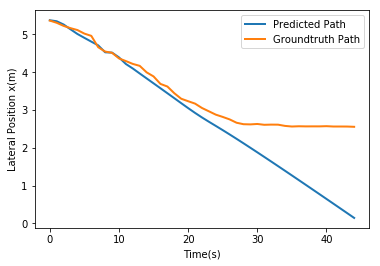

In [609]:
h1 =  plot_variable(filter_x, 'Lateral Position x(m)', 'Predicted Path')
# plt.legend(h1)
# plot_variable(meas_gty, 'meas x(m)')
h2 = plot_variable(gt_x, 'Lateral Position x(m)', 'Groundtruth Path')
plt.legend((h1, h2), ('Predicted Path', 'Groundtruth Path'))
plt.savefig('lat_pos0.png')

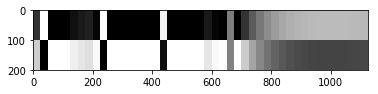

In [587]:
import cv2
def draw_bar(intermediate_state, state_name):
    img = np.zeros((100*2,25*len(intermediate_state[0][state_name]),3),np.uint8)
    for i in range(len(intermediate_state[0][state_name])):
        cv2.rectangle(img,(i*25,0),((i+1)*25+100,100),np.array((255,255,255))*(1-intermediate_state[0][state_name][i]),-1)
    for i in range(len(intermediate_state[0][state_name])):
        cv2.rectangle(img,(i*25,0+100),((i+1)*25+100,100+100),np.array((255,255,255))*intermediate_state[0][state_name][i],-1)
    plt.imshow(img,'brg')
    plt.axis('on')

draw_bar(intermediate_state, 'M')

## Estimate the Emission Probability $P(D_{min}^t|a_{sc}, b_{sc})$ based on MCMC

In [588]:
import random

def Ga(d_min, a, b):
    ave_logx, ave_x, n = d_min
    if a<=0 or b<=0:
        return 0
    else:
        return n*(a-1)*ave_logx - n*np.log(gamma(a)) - n*a*np.log(b) - n*ave_x/b

def MH(d_min, N):
    res = [[], []]
    last_a, last_b = random.random()*10, random.random()*10
    reject_cnt = 0
#     last_ave = np.array([0, 0])
    C = np.array([[1,0],[0,1]])*0.0005
    eps = C*1e-3
    for i in range(N):
        t = i+1
        u = random.random()
        [[a, b]] = np.random.multivariate_normal([last_a, last_b], C, 1)
        if a>0 and b >0 and u < min(1, np.exp(Ga(d_min, a, b)-Ga(d_min, last_a, last_b))):
            res[0].append(a)
            res[1].append(b)
            last_a = a
            last_b = b
        else:
            res[0].append(last_a)
            res[1].append(last_b)
            reject_cnt += 1
#         x = np.array([last_a, last_b])
#         ave = (last_ave*(t-1) + x)*1.0/t
#         C = (t-1)*1.0*C/t + (last_ave.T*last_ave - (t+1)*ave.T*ave*1.0/t + x.T*x*1.0 + eps)*2.4**2*0.5/t
#         last_ave = ave
    return res,reject_cnt

In [589]:
sc = [[],[]]
for i in range(len(train_list)):
    for j in range(len(train_list[i]['dmin'])):
        if isinstance(train_list[i]['dmin'][j], str):
            continue
        sc[train_list[i]['tags']['sitdang']=='true'].append(train_list[i]['dmin'][j])


log_sc = [[],[]]
log_sc[0] = [math.log(x) for x in sc[0]]
log_sc[1] = [math.log(x) for x in sc[1]]
Prob['Dmin'] = {}
Prob['Dmin']['a'] = [[],[]]
Prob['Dmin']['b'] = [[],[]]
mean_logx = [[],[]]
log_meanx = [[],[]]
for i in (0,1):
    mean_logx[i] = np.mean(log_sc[i])
    log_meanx[i] = math.log(np.mean(sc[i]))

In [590]:
d_min = [mean_logx[1], np.mean(sc[1]), len(sc[1])]
res,reject_cnt =MH(d_min, 50000)
print(reject_cnt*1.0/50000)


0.39772


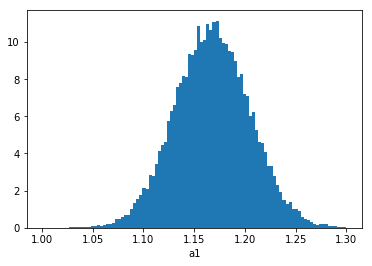

In [585]:
a, b = np.mean(res[0]), np.mean(res[1])
ha =plt.hist(res[0],100,range=(1.0,1.3),normed = True)
plt.xlabel('a1')
plt.savefig("a1.png")

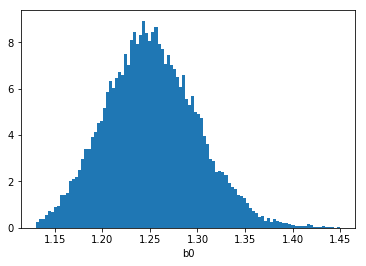

In [586]:
hb= plt.hist(res[1],100,range = (1.13, 1.45),normed = True)
plt.xlabel('b0')
plt.savefig("b1.png")

In [591]:
# ##################################### test Kalman #########################################
# P_mean_xGm_post = [np.matrix([[0],[0]]), np.matrix([[0],[0]])]
# P_covariance_xGm_post = [np.matrix([[INF,0],[0,INF]]), np.matrix([[INF,0],[0,INF]])]

# x_post = np.matrix([[0],[0]])
# P_post = np.matrix([[INF,0],[0,INF]])
# for i in range(3):
#     x_prior, P_prior = kf_predict(x_post, P_post, A[1],Q)
#     x_post, P_post, S = kf_update(x_prior, P_prior, R, H, -i*0.2)


# ######################### test predict, update and collapse ###############################
# P_mmzz_prior, P_mean_xmm_prior, P_covariance_xmm_prior = predict(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post)
# meas_y, d_min, meas_pos_e, meas_curb_pos_e = 2.6,'None','None','None'
# P_mmzz_post, P_mean_xmm_post, P_covariance_xmm_post = update(P_mmzz_prior, P_mean_xmm_prior, P_covariance_xmm_prior, meas_y, d_min, meas_pos_e, meas_curb_pos_e)
# P_mz_post, P_mean_xGm_post, P_covariance_xGm_post = collapse(P_mmzz_post, P_mean_xmm_post, P_covariance_xmm_post)

# filter_x = []
# meas_gty = []
# gt_x = []
# intermediate_state = [{'HSV':[], 'SV':[], 'AC':[], 'SC':[], 'M':[]} for _ in range(len(test_list))]

# # begin_predict_time = 

# for seq_id in range(len(test_list)):
#     seq = test_list[seq_id]
#     time_len = len(seq['ts'])
#     filter_seqx, meas_yy, gt_xx= [], [], []
# ##################### initialize every sequence before predict, update and collapse recursion ##################    
#     P_mz_post = P_mz_init
#     P_mean_xGm_post = [np.matrix([[0],[0]]), np.matrix([[0],[0]])]
#     P_covariance_xGm_post = [np.matrix([[INF,0],[0,INF]]), np.matrix([[INF,0],[0,INF]])]
    
#     for j in range(time_len):
#         ########## sensor data reading #########
#         meas_y = 'None' if isinstance(seq['meas_pos_e'][0][j],str) else seq['meas_pos_e'][0][j]
#         d_min = 'None' if isinstance(seq['dmin'][j],str) else seq['dmin'][j]
#         meas_curb_pos_e = 'None' if isinstance(seq['meas_curb_pos_e'][0][j],str) else seq['meas_curb_pos_e'][0][j]
#         gt_pos_e = 'None' if isinstance(seq['gt_pos_e'][0][j],str) else seq['gt_pos_e'][0][j]
#         meas_pos_e = meas_y
        
#         ######### through dynamic bayesian network ##########
#         P_mz_post, P_mean_xGm_post, P_covariance_xGm_post =\
#             dbn(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post, meas_y, d_min, meas_pos_e, meas_curb_pos_e)
        
#         ########### result post process and intermediate result such as latent state recording #########
#         State = post_processing(P_mz_post, P_mean_xGm_post, P_covariance_xGm_post)
        
#         intermediate_state[seq_id]['HSV'].append(State['HSV'])
#         intermediate_state[seq_id]['SV'].append(State['SV'])
#         intermediate_state[seq_id]['AC'].append(State['AC'])
#         intermediate_state[seq_id]['SC'].append(State['SC'])
#         intermediate_state[seq_id]['M'].append(State['M'])
        
#         filter_seqx.append(float(H*State['x']))
#         meas_yy.append(meas_y) if meas_y != 'None' else meas_yy.append(meas_yy[-1])
#         gt_xx.append(seq['gt_pos_e'][0][j]) if gt_pos_e != 'None' else gt_xx.append(gt_xx[-1])
    
#     filter_x.append(filter_seqx)
#     meas_gty.append(meas_yy)
#     gt_x.append(gt_xx)

In [562]:
##################### P(HO_t | SV_t) ###########################

############################### try multi naive bayesian, it does not work either ###################################

# Prob['HO'] = MultinomialNB()

# HO_train_X = []
# HO_train_Y = []
# # for i in range(len(train_list)):
# for j in range(10):
#     if isinstance(train_list[i]['meas_head_experts'][0][j], str):
#         continue
#     temp_sum = 0.
#     for k in range(8):
#         temp_sum += train_list[i]['meas_head_experts'][k][j]
#     HO_train_X.append(np.array([train_list[i]['meas_head_experts'][k][j]/temp_sum for k in range(0,1)]))
#     HO_train_Y.append(train_list[i]['sv'][j])
# HO_train_X = np.vstack(HO_train_X)
# HO_train_Y = np.array(HO_train_Y)
# Prob['HO'].fit(HO_train_X, HO_train_Y)


# ojbk, wtf = 0,0
# for i in range(len(train_list)):
#     for j in range(len(train_list[i]['tte'])):
#         if isinstance(train_list[i]['meas_head_experts'][0][j], str):
#             continue
#         P_sv = Prob['HO'].predict([np.array([train_list[i]['meas_head_experts'][k][j] for k in range(0,1)])])
#         print(P_sv)
# #         if (P_sv[0][0]> P_sv[0][1] and train_list[i]['sv'][j]==0) or (P_sv[0][0]< P_sv[0][1] and train_list[i]['sv'][j]==1):
# # #             print("ojbk")
# #             ojbk += 1
# #         else:
# # #             print("wtf")
# #             wtf += 1

# print(HO_train_X)
# print(HO_train_X.shape)
# print('ojbk:',ojbk)
# print('wtf:',wtf)

##################### try multinomial distribution, it does not work #############################################

# Prob['HO'] = [np.zeros(8), np.zeros(8)]
# sv_count = [0,0]
# for i in range(len(train_list)):
#     for j in range(len(train_list[i]['tte'])):
#         if isinstance(train_list[i]['meas_head_experts'][0][j], str):
#             continue
#         temp_sum = 0.
#         for k in range(8):
#             temp_sum += train_list[i]['meas_head_experts'][k][j]
#         for k in range(8):
#             Prob['HO'][train_list[i]['sv'][j]][k] += train_list[i]['meas_head_experts'][k][j]/temp_sum
#         sv_count[train_list[i]['sv'][j]] += 1

# for i in (0,1):
#     Prob['HO'][i]/=sv_count[i]
#     Prob['HO'][i]/=np.sum(Prob['HO'][i])

    
# sv_count /= np.sum(sv_count)
# print(Prob['HO'])
# print(sv_count)

## We attribute this to the wired statistics of the data we obtained. 